In [25]:
import json

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor

%load_ext autoreload
%autoreload 2

from app.helpers.mutation_util import (
    get_loci_set,
    maybe_get_seq_id_error_message,
    process_and_validate_evolve_input_files,
    get_measured_and_unmeasured_mutant_seq_ids,
    get_cross_validation_holdout_sets,
    get_cv_splits
)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
wt_aa_seq = 'MEHLYLSLVLLFVSSISLSLFFLFYKHKSMFTGANLPPGKIGYPLIGESLEFLSTGWKGHPEKFIFDRMSKYSSQIFKTSILGEPTAVFPGAVCNKFLFSNENKLVNAWWPASVDKIFPSSLQTSSKEEAKKMRKLLPQFLKPEALHRYIGIMDSIAQRHFADSWENKNQVIVFPLAKRYTFWLACRLFISVEDPTHVSRFADPFQLLAAGIISIPIDLPGTPFRKAINASQFIRKELLAIIRQRKIDLGEGKASPTQDILSHMLLTCDENGQYMNELDIADKILGLLVGGHDTASAACTFVVKFLAELPHIYEQVYKEQMEIAKSKVPGELLNWEDIQKMKYSWNVACEVMRLAPPLQGAFREAITDFVFNGFSIPKGWKLYWSANSTHKSPDYFPEPDKFDPTRFEGNGPAPYTFVPFGGGPRMCPGKEYARLEILVFMHNLVKRFKWEKLVPDEKIVVDPMPIPAKGLPVRLYPHKA'
raw_embedding_df = pd.read_csv('integration_tests/testdata/000001/embed/000001_embeddings_esmc_600m_batch1.csv')
raw_activity_df = pd.read_excel('/Users/jacobroberts/Desktop/241231_test_oa_activity_data.xlsx')


In [52]:
# raw_activity_df = raw_activity_df.groupby('seq_id').agg({'activity': 'mean', 'seq_id': 'first'})

In [53]:
activity_df, embedding_df = process_and_validate_evolve_input_files(wt_aa_seq, raw_activity_df, raw_embedding_df)

In [54]:
measured_mutants, unmeasured_mutants = get_measured_and_unmeasured_mutant_seq_ids(
    activity_df, embedding_df
)

# Convert JSON strings to lists and stack them into a 2D numpy array
X_train = np.vstack(
    [json.loads(x) for x in embedding_df.loc[activity_df.index].embedding]
)
y_train = activity_df.activity.to_numpy()
 

In [55]:
model = RandomForestRegressor(
    n_estimators=100,
    criterion="friedman_mse",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=1.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=1,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
)
model.fit(X_train, y_train)

RandomForestRegressor(criterion='friedman_mse', random_state=1)

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 1. Get predictions on the training set
y_pred = model.predict(X_train)

In [57]:
# 2. Compute and print basic metrics
r2 = r2_score(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_train, y_pred)

print("Training Spearman:", spearmanr(y_train, y_pred).correlation)
print("Training MSE:", mse)
print("Training RMSE:", rmse)
print("Training MAE:", mae)

Training Spearman: 0.8963240840700537
Training MSE: 25675.12929477406
Training RMSE: 160.23460704471447
Training MAE: 109.78701905507317


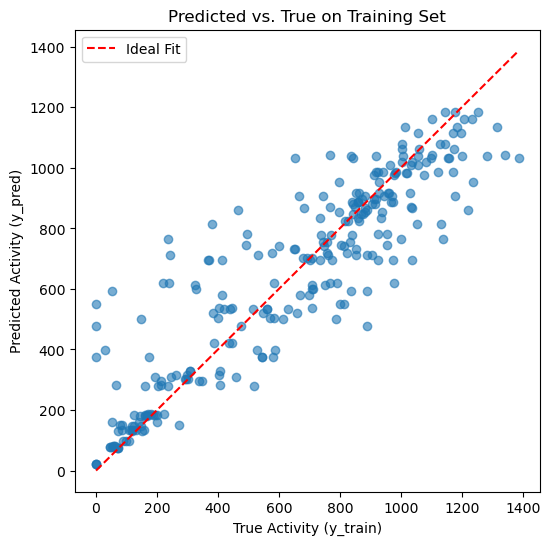

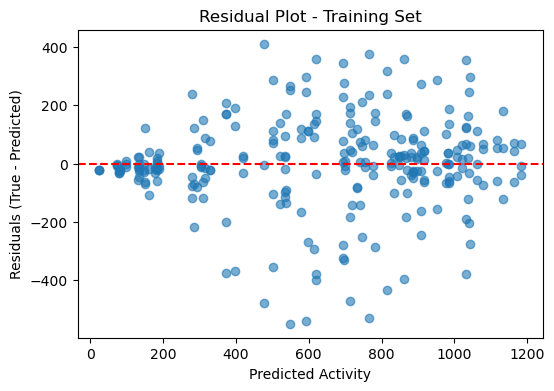

In [58]:
# 3. Plot true vs. predicted values
plt.figure(figsize=(6, 6))
plt.scatter(y_train, y_pred, alpha=0.6)
plt.plot([y_train.min(), y_train.max()],
         [y_train.min(), y_train.max()],
         'r--', label='Ideal Fit')
plt.xlabel('True Activity (y_train)')
plt.ylabel('Predicted Activity (y_pred)')
plt.title('Predicted vs. True on Training Set')
plt.legend()
plt.show()

# 4. (Optional) Plot the residuals
residuals = y_train - y_pred
plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Activity')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residual Plot - Training Set')
plt.show()

# Cool. Now cross-validate.

In [59]:
cv_holdout_sets, cv_viable_loci = get_cross_validation_holdout_sets(
  measured_mutants,
  min_held_out_mutants=5,
  max_held_out_mutants=12
)
len(cv_holdout_sets), len(cv_viable_loci)

(35, 35)

In [60]:
cv_splits = get_cv_splits(activity_df.index, cv_holdout_sets, n_splits=10)
for train_indices, test_indices in cv_splits:
    print(f'{100.0 * len(test_indices) / (len(train_indices) + len(test_indices)):.1f}% in holdout')

6.8% in holdout
5.7% in holdout
6.8% in holdout
6.8% in holdout
5.7% in holdout
8.7% in holdout
6.8% in holdout
6.8% in holdout
6.8% in holdout
6.8% in holdout
5.7% in holdout
6.8% in holdout
6.8% in holdout
5.7% in holdout
6.8% in holdout
6.8% in holdout
6.8% in holdout
6.8% in holdout
6.8% in holdout
9.1% in holdout
9.1% in holdout
6.8% in holdout
6.8% in holdout
6.8% in holdout
8.0% in holdout
6.8% in holdout
8.0% in holdout
5.7% in holdout
6.8% in holdout
8.3% in holdout
6.1% in holdout
6.8% in holdout
6.8% in holdout
5.7% in holdout
9.1% in holdout


In [61]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from scipy.stats import spearmanr

# Custom scorer using Spearman correlation
def spearman_scorer(y_true, y_pred):
    return spearmanr(y_true, y_pred).correlation

spearman_score = make_scorer(spearman_scorer, greater_is_better=True)

# scores = cross_val_score(model, X_train, y_train, cv=cv_splits, scoring='r2', n_jobs=-1)
scores = cross_val_score(model, X_train, y_train, cv=cv_splits, scoring=spearman_score, n_jobs=-1)

In [62]:
pd.Series(scores).describe()

count    35.000000
mean      0.449197
std       0.261297
min      -0.222588
25%       0.354260
50%       0.480079
75%       0.634623
max       0.840404
dtype: float64

In [63]:
print("Cross-Val spearman scores:", scores)
print("Mean spearman:", np.mean(scores))
print("Std spearman:", np.std(scores))

Cross-Val spearman scores: [ 0.39188034  0.45825757  0.35425983  0.35425983  0.44734667  0.37664612
 -0.22258803  0.63641367  0.3229094   0.14734701  0.25095057 -0.12226667
 -0.12226667  0.36005952  0.72419487  0.55490256  0.68657435  0.68657435
  0.78062564  0.44969748  0.44969748  0.7116547   0.56744273  0.5360923
  0.78247068  0.5360923   0.78247068  0.63283188  0.0658359   0.84040435
  0.49634616  0.51728205  0.51728205  0.48007936  0.29012741]
Mean spearman: 0.449196812310724
Std spearman: 0.25753708800755615


Text(0.5, 1.0, 'Distribution of CV Spearman Scores')

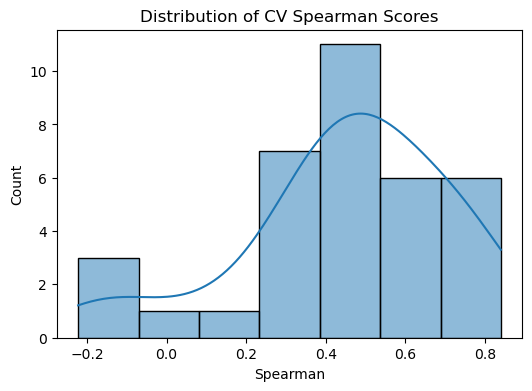

In [64]:
plt.figure(figsize=(6,4))
sns.histplot(scores, kde=True)
plt.xlabel("Spearman")
plt.ylabel("Count")
plt.title("Distribution of CV Spearman Scores")

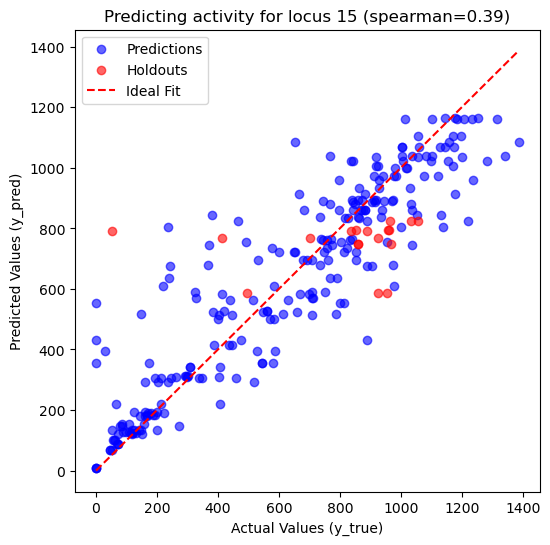

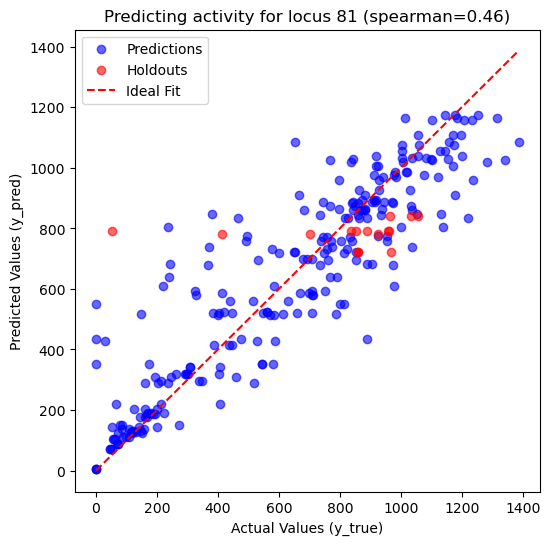

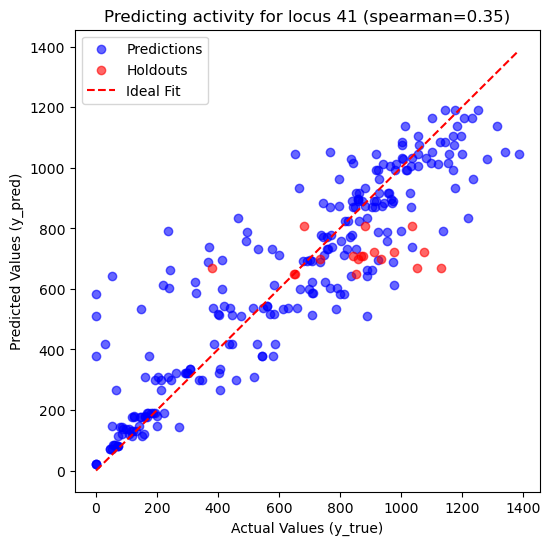

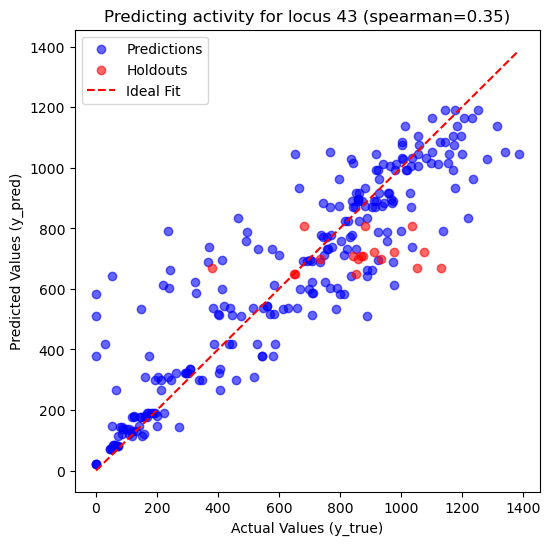

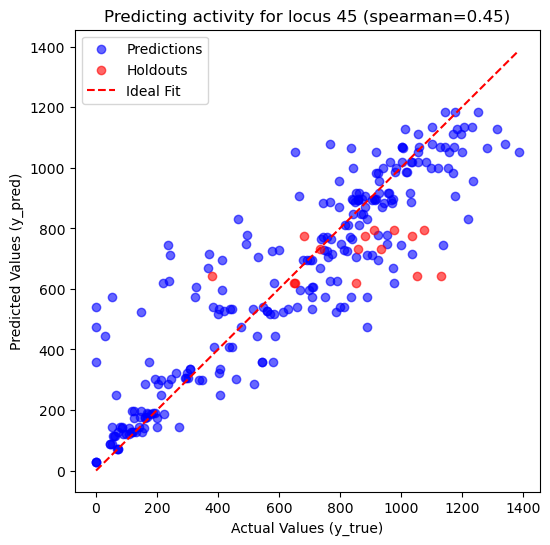

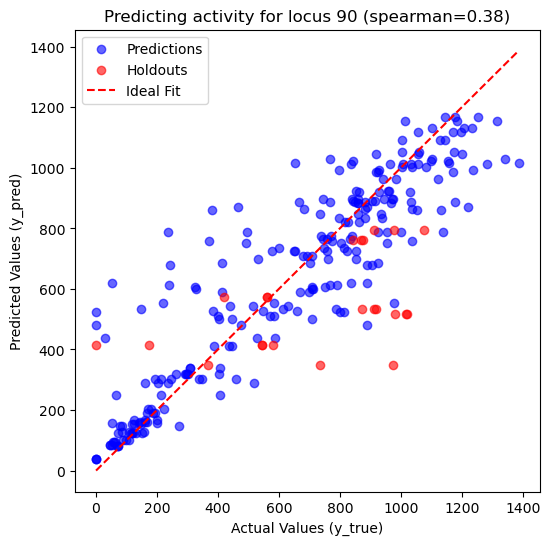

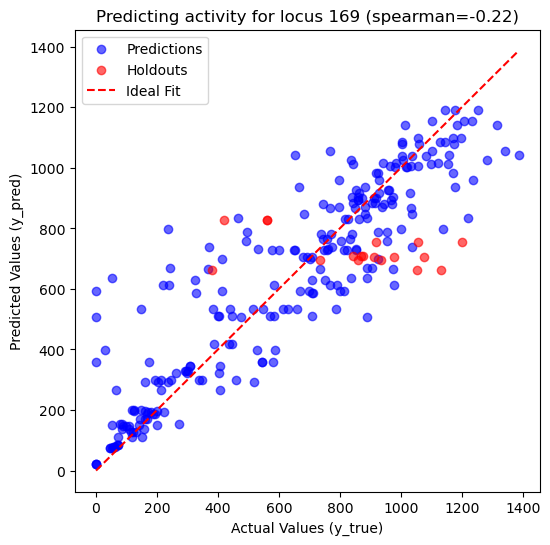

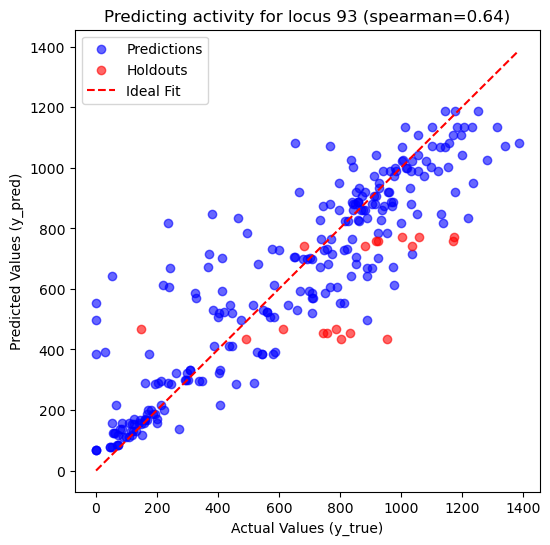

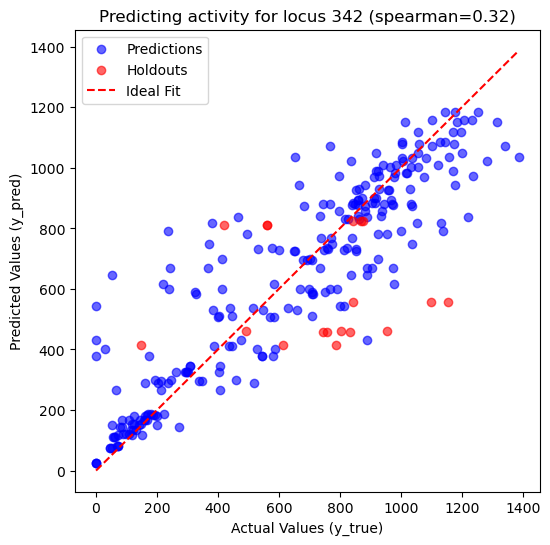

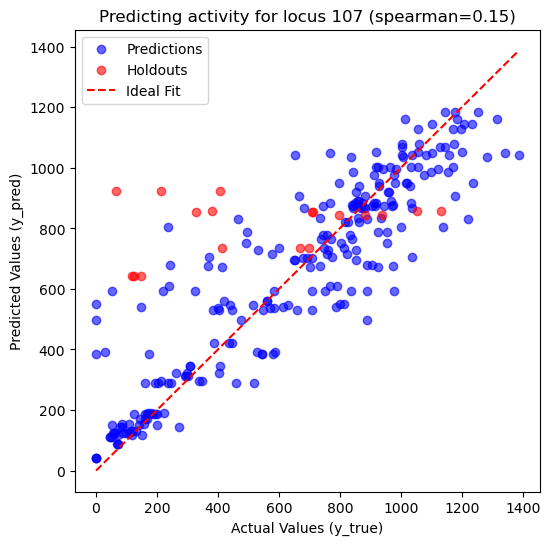

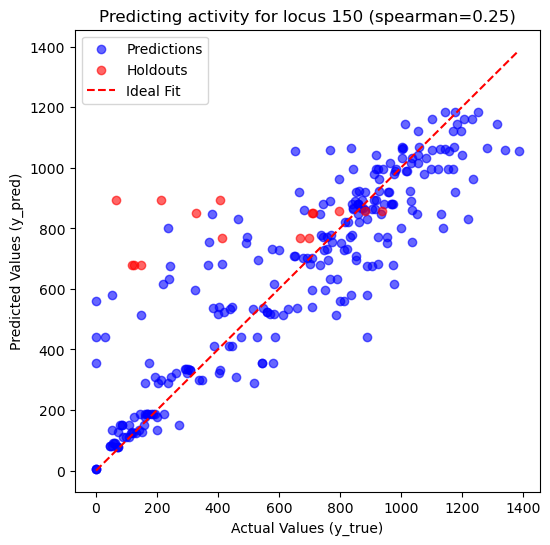

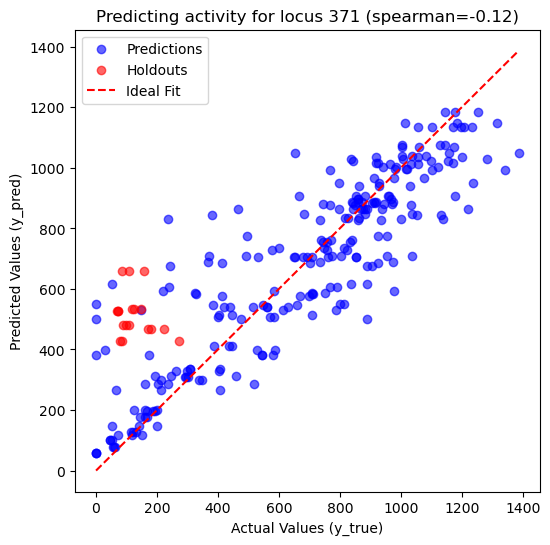

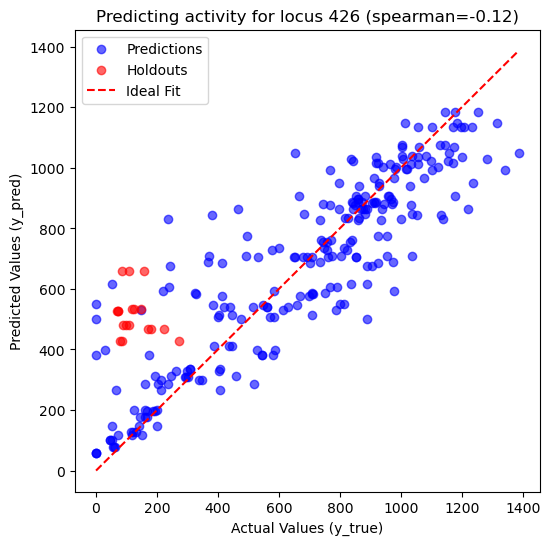

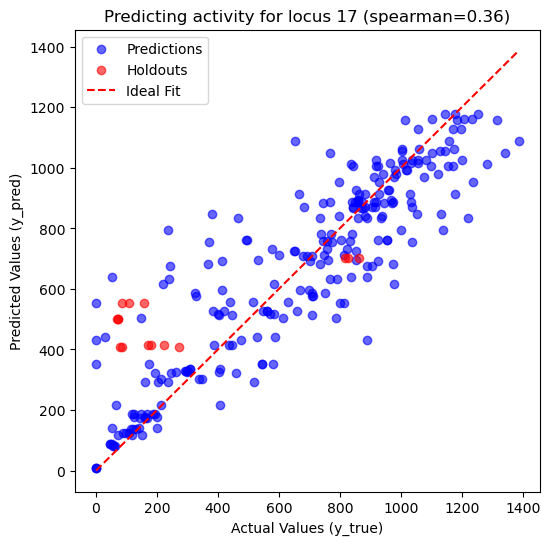

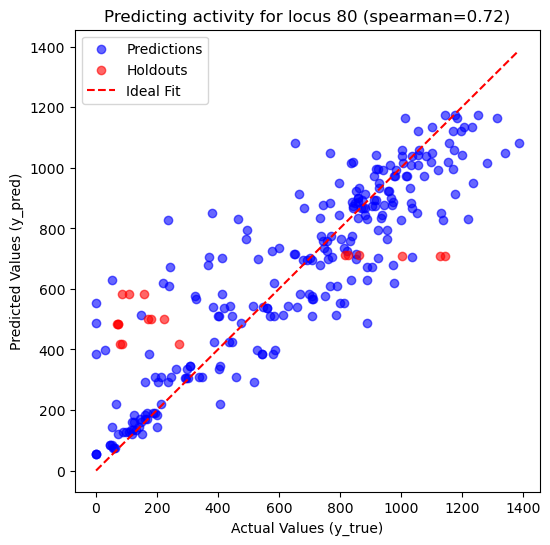

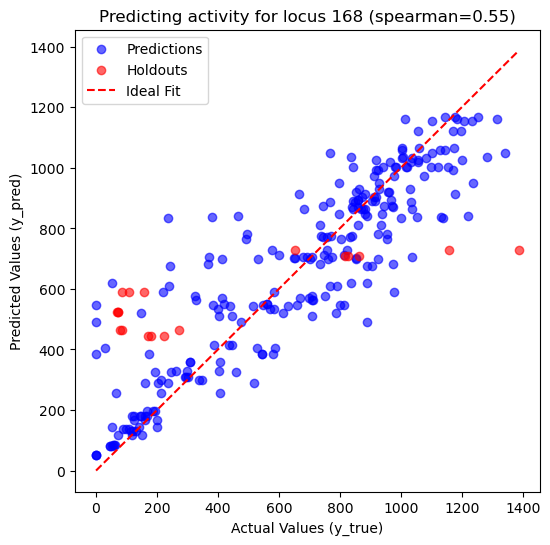

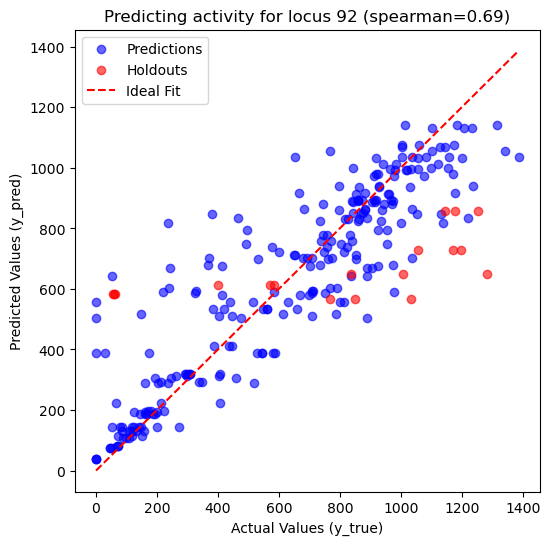

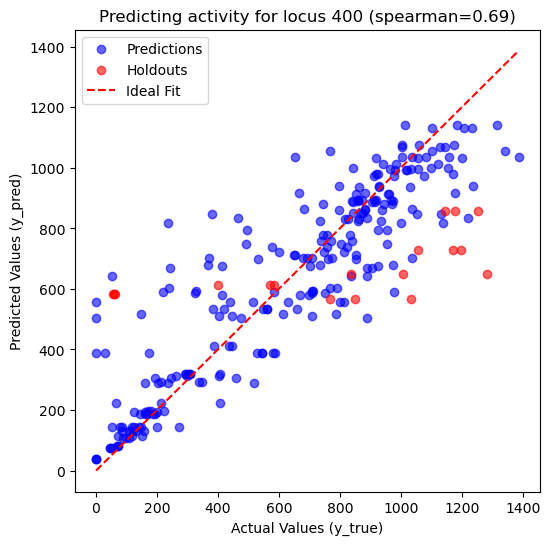

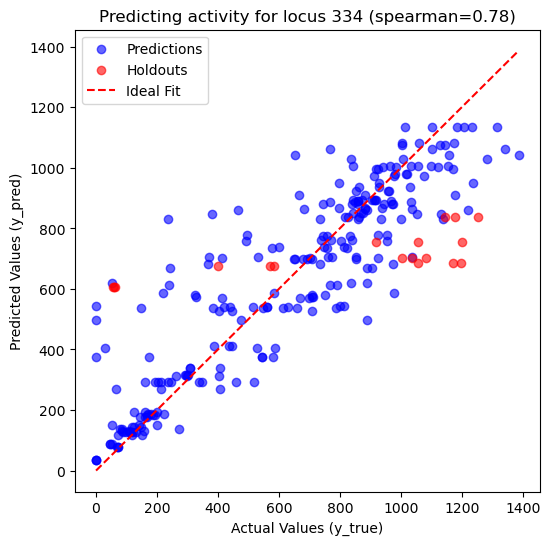

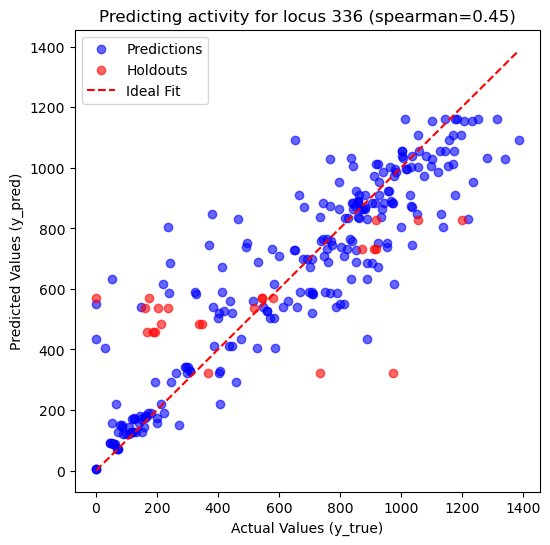

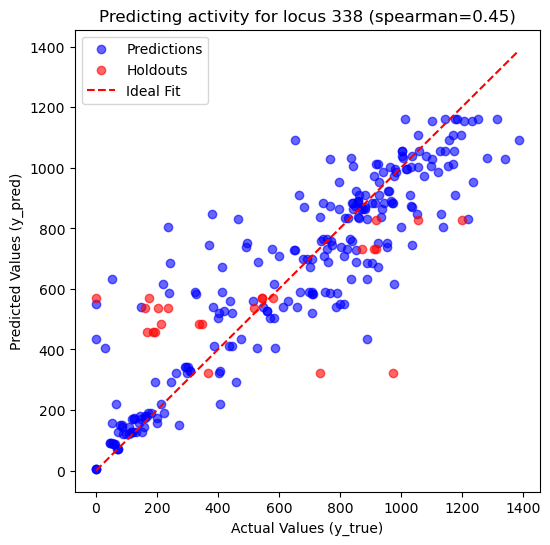

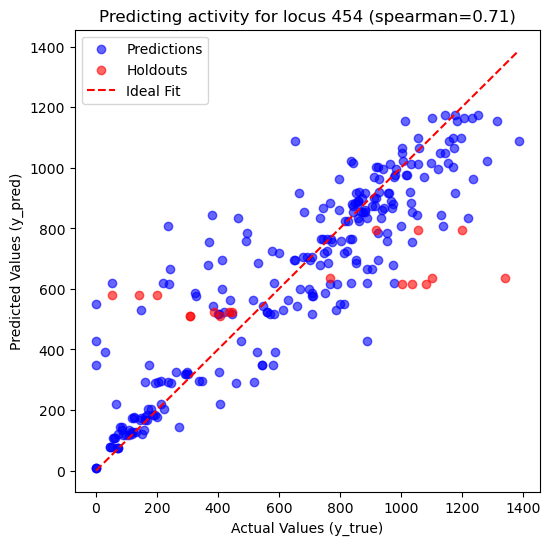

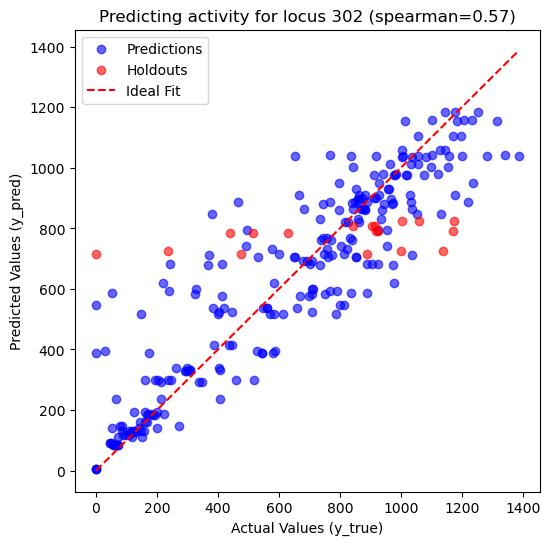

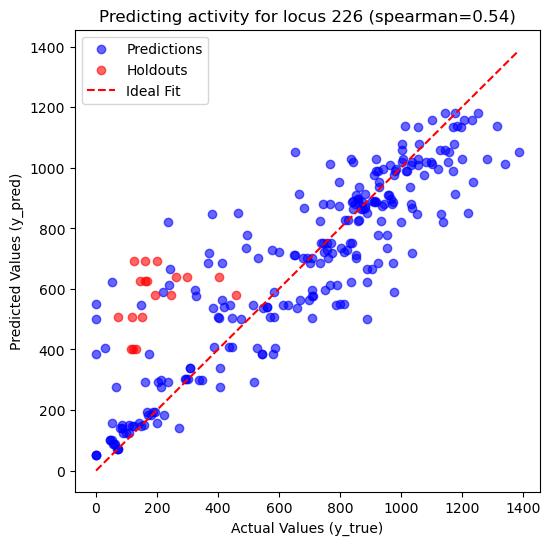

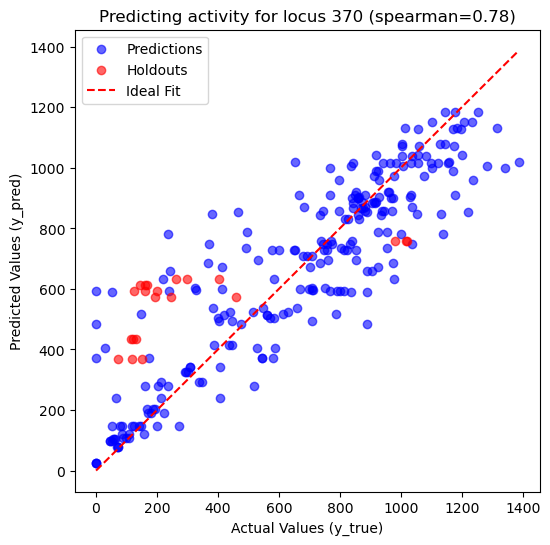

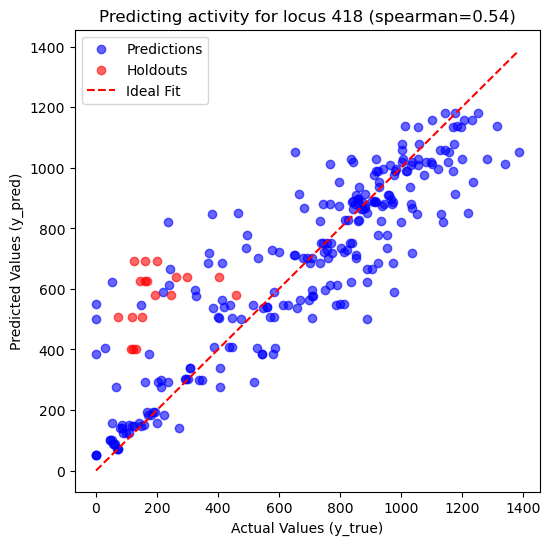

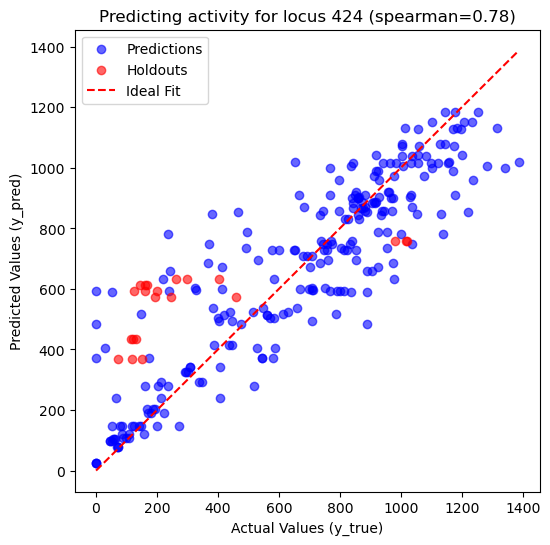

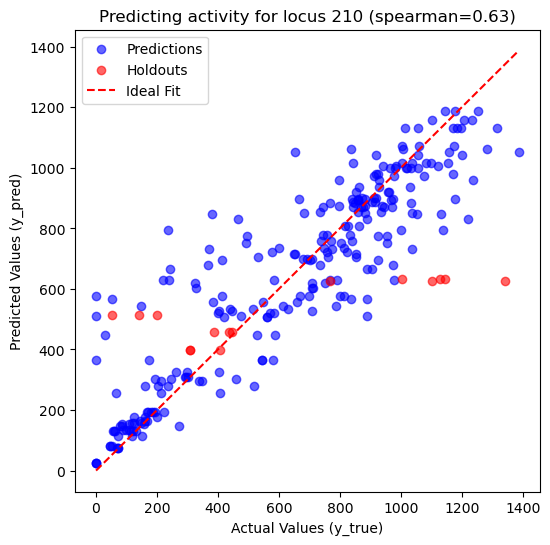

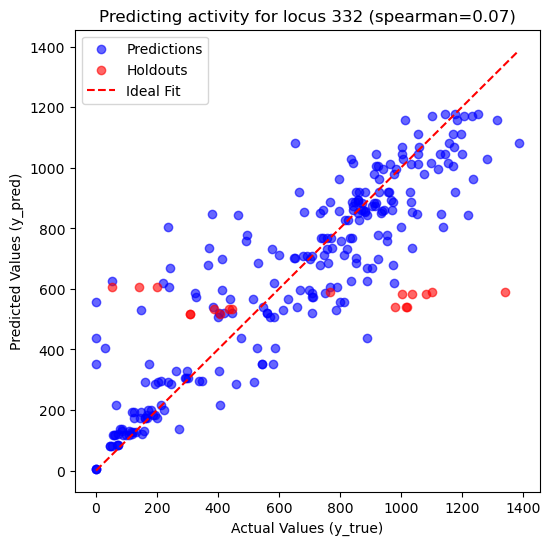

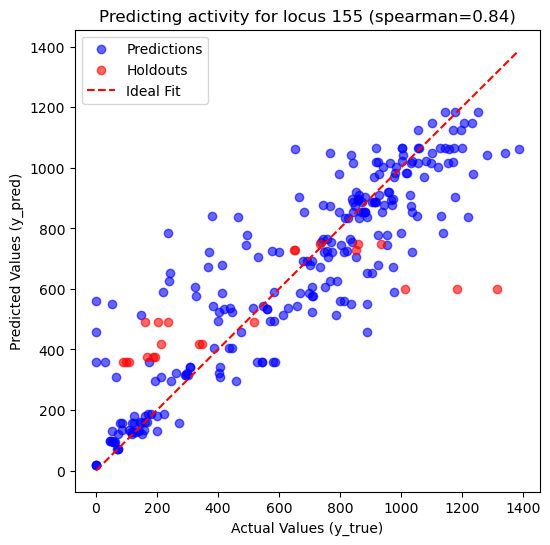

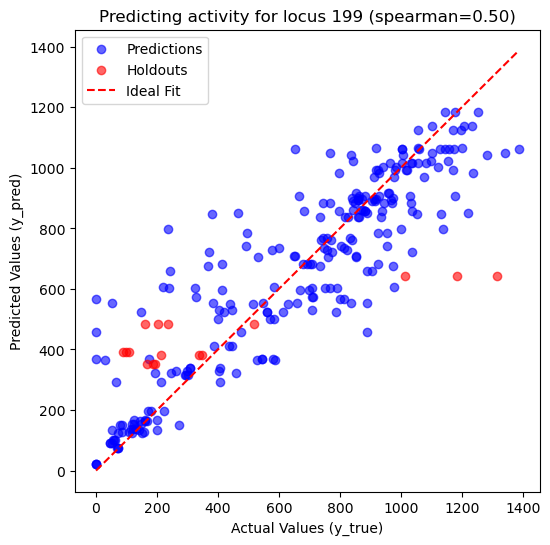

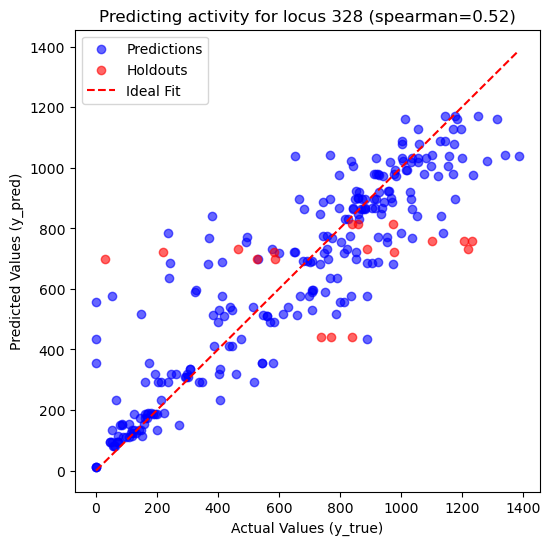

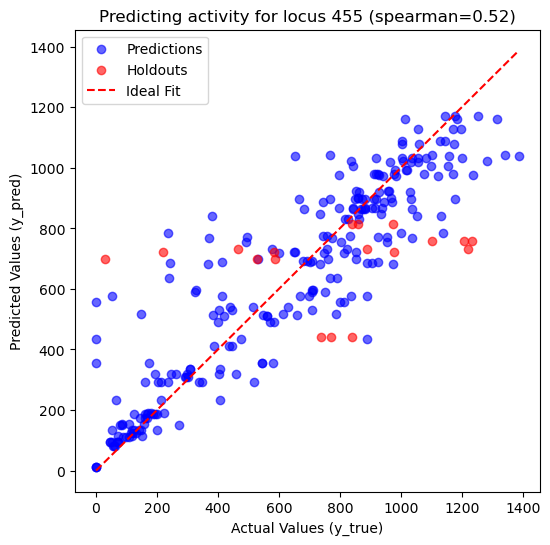

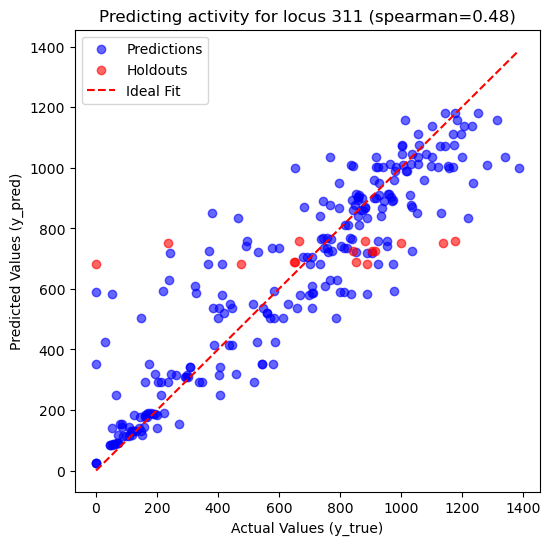

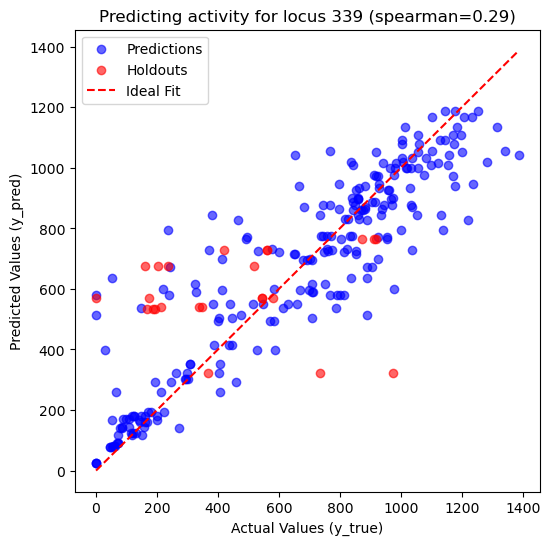

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

def plot_fold_predictions(model, X, y, cv_split, title="Fold Results: Predicted vs. Actual"):
    """
    Plots predicted vs. actual values for a single fold in custom cross-validation.
    
    Parameters:
        model : trained model (e.g., RandomForestRegressor)
            The fitted model to use for predictions.
        X : array-like, shape (n_samples, n_features)
            Feature matrix.
        y : array-like, shape (n_samples,)
            Target values.
        cv_split : tuple of lists
            A tuple (train_indices, test_indices) defining the fold split.
        title : str
            Custom title for the plot.
    
    Returns:
        None
    """
    train_indices, test_indices = cv_split

    # Train the model on the train split
    model.fit(X[train_indices], y[train_indices])
    y_train_pred = model.predict(X[train_indices])
    y_train_true = y[train_indices]

    # Predict on the test split
    y_test_pred = model.predict(X[test_indices])
    y_test_true = y[test_indices]

    # Plot predicted vs. actual
    plt.figure(figsize=(6, 6))
    plt.scatter(y_train_true, y_train_pred, alpha=0.6, label="Predictions", color='blue')
    plt.scatter(y_test_true, y_test_pred, alpha=0.6, label="Holdouts", color='red')
    plt.plot([y.min(), y.max()],
             [y.min(), y.max()],
             'r--', label="Ideal Fit")
    plt.xlabel("Actual Values (y_true)")
    plt.ylabel("Predicted Values (y_pred)")
    # plt.title(f'{title} (R^2={r2_score(y_test_true, y_test_pred):.2f})')
    plt.title(f'{title} (spearman={spearmanr(y_test_true, y_test_pred).correlation:.2f})')
    plt.legend()
    plt.show()

for ii in range(len(cv_splits)):
  plot_fold_predictions(model, X_train, y_train, cv_splits[ii], title=f'Predicting activity for locus {cv_viable_loci[ii]}')

# Spearman actually looks quite good!

Note that R2 did not. But R2 is not a good metric for this problem.

In [66]:
X_unmeasured = np.vstack(
    # [json.loads(x) for x in embedding_df.loc[unmeasured_mutants].embedding]
    [json.loads(x) for x in embedding_df.loc[measured_mutants + unmeasured_mutants].embedding]
)
X_unmeasured.shape

(10167, 1152)

In [67]:
y_unmeasured_pred = model.predict(X_unmeasured)


In [68]:
unmeasured_df = pd.DataFrame({
    # 'seq_id': unmeasured_mutants,
    'seq_id': measured_mutants + unmeasured_mutants,
    'predicted_activity': y_unmeasured_pred,
})
unmeasured_df.index = unmeasured_df.seq_id
unmeasured_df['relevant_measured_mutants'] = unmeasured_df.seq_id.apply(
  lambda unmeasured_seq_id: ' '.join([
    m for m in measured_mutants if get_loci_set(m) & get_loci_set(unmeasured_seq_id)
  ])
)
unmeasured_df['actual_activity'] = unmeasured_df.join(
  activity_df.groupby(level=0).activity.mean(), how='left').activity
unmeasured_df = unmeasured_df.sort_values('predicted_activity', ascending=False)
unmeasured_df.to_csv('~/Downloads/predicted_activities_evolvepro.csv')

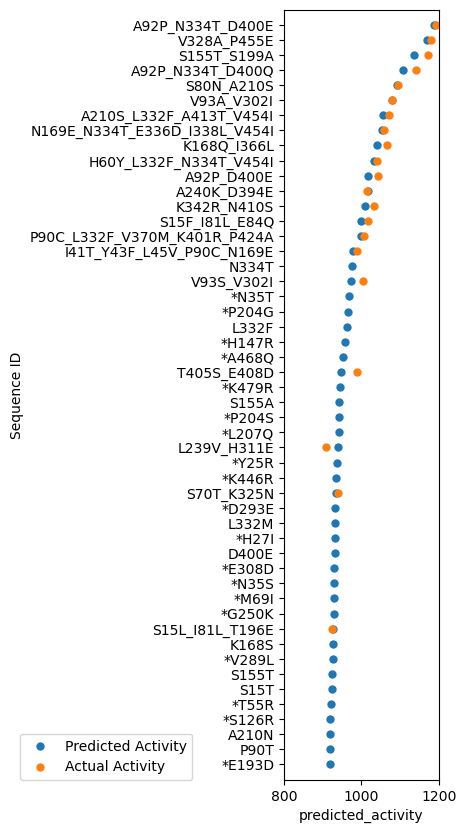

In [69]:
from matplotlib import pyplot as plt
plotting_df = unmeasured_df.iloc[:50].copy()
plotting_df['Sequence ID'] = plotting_df.apply(lambda r: f'{"" if r.relevant_measured_mutants else "*"}{r.seq_id}', axis=1)
plt.figure(figsize=(2,10))
ax = sns.scatterplot(data=plotting_df, 
                     y='Sequence ID', 
                     x='predicted_activity', 
                     linewidth=0,
                     label='Predicted Activity')

ax = sns.scatterplot(data=plotting_df, 
                     y='Sequence ID', 
                     x='actual_activity', 
                     linewidth=0,
                     label='Actual Activity')
ax.set_ylim(50, -1)  # Reverse y-axis to maintain same order
ax.set_xlim(800, 1200)
ax.legend(loc='lower left', 
         bbox_to_anchor=(-1.7, 0),  # Move legend left of plot
         borderaxespad=0)  # Reduce padding
